In [1]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(folium.__version__)

0.2.1


# Download Data

In [2]:
!wget "https://s3.amazonaws.com/divvy-data/tripdata/Divvy_Trips_2016_Q3Q4.zip"

--2017-02-25 13:23:52--  https://s3.amazonaws.com/divvy-data/tripdata/Divvy_Trips_2016_Q3Q4.zip
Resolving s3.amazonaws.com... 54.231.114.186
Connecting to s3.amazonaws.com|54.231.114.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57215032 (55M) [application/zip]
Saving to: 'Divvy_Trips_2016_Q3Q4.zip'

Divvy_Trips_2016_Q3 100%[=====================>]  54.56M  3.74MB/s   in 16s    

2017-02-25 13:24:09 (3.39 MB/s) - 'Divvy_Trips_2016_Q3Q4.zip' saved [57215032/57215032]



In [3]:
!mkdir data
!mv Divvy_Trips_2016_Q3Q4.zip data/Divvy_Trips_2016_Q3Q4.zip

In [4]:
!unzip data/Divvy_Trips_2016_Q3Q4.zip -d data/Divvy_Trips_2016_Q3Q4

Archive:  data/Divvy_Trips_2016_Q3Q4.zip
  inflating: data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q4.csv  
  inflating: data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q3.csv  
  inflating: data/Divvy_Trips_2016_Q3Q4/README_2016_Q4.txt  
  inflating: data/Divvy_Trips_2016_Q3Q4/README_2016_Q3.txt  
  inflating: data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q3.csv  
  inflating: data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q4.csv  


# Load Stations

In [5]:
divvyStations_q3 = pd.read_csv('data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q3.csv')
divvyStations_q4 = pd.read_csv('data/Divvy_Trips_2016_Q3Q4/Divvy_Stations_2016_Q4.csv')

In [6]:
# combine and keep the first instance of id
divvyStations = pd.concat([divvyStations_q3, divvyStations_q4], axis=0).drop_duplicates(subset=['id'])

In [7]:
divvyStations.head()

,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880420,-87.655599,19,6/26/2013


In [8]:
# convert to (n, 2) nd-array format for heatmap
stationArr = divvyStations[['latitude', 'longitude']].as_matrix()

# Create Folium map of Station locations centered around Chicago

In [9]:
m = folium.Map([41.8781, -87.6298], 
               zoom_start=11)
m

In [10]:
for index, row in divvyStations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

In [11]:
# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

# Analyze trip file to see most used stations for starting and ending trips

## Load Trip Data

In [12]:
# Using generators to read and concatenate multiple dataframes
# Adapted from: http://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

In [13]:
divvyTripFiles = ['data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q3.csv', 
                  'data/Divvy_Trips_2016_Q3Q4/Divvy_Trips_2016_Q4.csv']

divvyTrips = (pd.read_csv(f) for f in divvyTripFiles)
divvyTripsCombined = pd.concat(divvyTrips, ignore_index=True)

In [14]:
divvyTripsCombined.describe(include='all')

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
count,2.125643e+06,2125643,2125643,2.125643e+06,2.125643e+06,2.125643e+06,2125643,2.125643e+06,2125643,2125643,1590189,1.590343e+06
unique,NaN,1846706,1779098,NaN,NaN,NaN,584,NaN,584,3,2,NaN
top,NaN,8/28/2016 13:34:22,7/23/2016 12:54:37,NaN,NaN,NaN,Streeter Dr & Grand Ave,NaN,Streeter Dr & Grand Ave,Subscriber,Male,NaN
freq,NaN,7,17,NaN,NaN,NaN,59247,NaN,64948,1589954,1180122,NaN
mean,1.169926e+07,NaN,NaN,3.251980e+03,1.008547e+03,1.799161e+02,NaN,1.803518e+02,NaN,NaN,NaN,1.980787e+03
std,7.313875e+05,NaN,NaN,1.730437e+03,1.816103e+03,1.305240e+02,NaN,1.304878e+02,NaN,NaN,NaN,1.075399e+01
min,1.042666e+07,NaN,NaN,1.000000e+00,6.000000e+01,2.000000e+00,NaN,2.000000e+00,NaN,NaN,NaN,1.899000e+03
25%,1.106635e+07,NaN,NaN,1.755000e+03,4.160000e+02,7.500000e+01,NaN,7.500000e+01,NaN,NaN,NaN,1.975000e+03
50%,1.170150e+07,NaN,NaN,3.446000e+03,7.160000e+02,1.570000e+02,NaN,1.570000e+02,NaN,NaN,NaN,1.984000e+03
75%,1.233129e+07,NaN,NaN,4.802000e+03,1.195000e+03,2.680000e+02,NaN,2.720000e+02,NaN,NaN,NaN,1.989000e+03


In [15]:
# Three usertypes? This wasn't mentioned in the readme. Let's investigate
divvyTripsCombined.groupby('usertype')['trip_id'].agg(len)

usertype
Customer       535649
Dependent          40
Subscriber    1589954
Name: trip_id, dtype: int64

In [16]:
## There is a 'Dependent' usertype with 40 entries, let's drop this
divvyTripsCombined = divvyTripsCombined[divvyTripsCombined.usertype != 'Dependent']

## Same Station Trip Analysis

In [17]:
# Curious, how many trips went from Station A all the way to Station A
totalTrips = len(divvyTripsCombined)
sameStationTrips = divvyTripsCombined[divvyTripsCombined.from_station_id == divvyTripsCombined.to_station_id]
sameStationTrips.is_copy = False

In [18]:
print ('Total number of trips: {:,}'.format(totalTrips))
print (('Trips from A -> A: {:,}').format(len(sameStationTrips)))
print (('Trips from A -> A: {:.1%}').format(len(sameStationTrips) / totalTrips))

Total number of trips: 2,125,603
Trips from A -> A: 73,730
Trips from A -> A: 3.5%


In [19]:
# % of same station trips by usertype
num_trips_by_usertype = divvyTripsCombined.groupby('usertype')['trip_id'].agg(len)
num_same_station_trips_by_usertype = sameStationTrips.groupby('usertype')['trip_id'].agg(len)
num_same_station_trips_by_usertype / num_trips_by_usertype

usertype
Customer      0.090636
Subscriber    0.015838
Name: trip_id, dtype: float64

In [20]:
# How long are these trips? Accidental checkouts?
# Who is taking them?
# Where are they taking them?
# Tourists who don't know where the next station is? Or subscribes running errards around the neighbourhood?

sameStationTrips['tripInMinutes'] = sameStationTrips['tripduration'] / 60
sameStationTrips.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,tripInMinutes
count,7.373000e+04,73730.000000,73730.000000,73730.000000,73730.000000,25204.000000,73730.000000
mean,1.151064e+07,3219.399769,2360.523261,192.533473,192.533473,1980.622798,39.342054
std,6.886428e+05,1731.021515,4078.805054,153.248962,153.248962,11.690790,67.980084
min,1.042666e+07,1.000000,60.000000,2.000000,2.000000,1900.000000,1.000000
25%,1.091862e+07,1716.000000,504.000000,69.000000,69.000000,1974.000000,8.400000
50%,1.144692e+07,3395.000000,1383.000000,164.000000,164.000000,1985.000000,23.050000
75%,1.205419e+07,4764.000000,2888.000000,291.000000,291.000000,1989.000000,48.133333
max,1.297922e+07,5919.000000,86365.000000,620.000000,620.000000,2000.000000,1439.416667


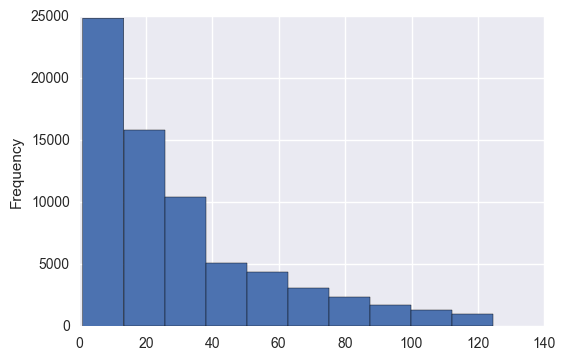

In [21]:
# check out trip in minutes distrubtion
tripDuration = sameStationTrips['tripInMinutes']
tripDuration[tripDuration < tripDuration.quantile(.95)].plot(kind='hist')

In [22]:
divvyTripsCombined.head(2)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,12150160,9/30/2016 23:59:58,10/1/2016 00:04:03,4959,245,69,Damen Ave & Pierce Ave,17,Wood St & Division St,Subscriber,Male,1988.0
1,12150159,9/30/2016 23:59:58,10/1/2016 00:04:09,2589,251,383,Ashland Ave & Harrison St,320,Loomis St & Lexington St,Subscriber,Female,1990.0


usertype
Customer      Axes(0.125,0.125;0.775x0.775)
Subscriber    Axes(0.125,0.125;0.775x0.775)
Name: tripInMinutes, dtype: object

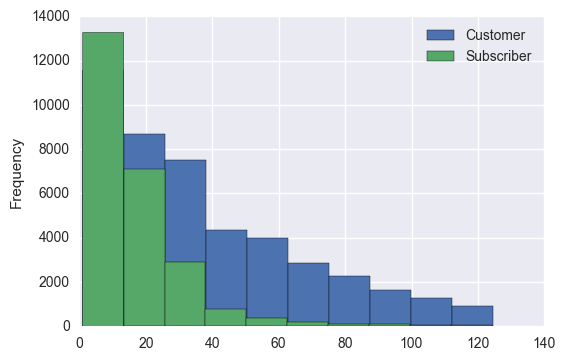

In [23]:
sameStationTrips[tripDuration < 
                 tripDuration.quantile(.95)].groupby('usertype')['tripInMinutes'].plot(kind='hist', 
                                                                                       stacked=True, 
                                                                                       legend=True)

usertype
Customer      Axes(0.125,0.125;0.775x0.775)
Subscriber    Axes(0.125,0.125;0.775x0.775)
Name: tripInMinutes, dtype: object

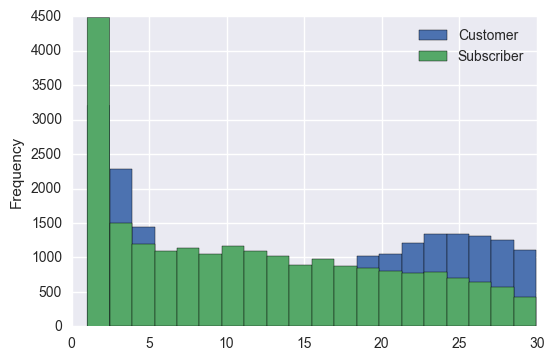

In [24]:
# Divvy's charge more for rides larger than 30 minutes so lets see that
# distribution of usage for less than 30
sameStationTrips[sameStationTrips['tripInMinutes'] < 30] \
    .groupby('usertype')['tripInMinutes'] \
    .plot(kind='hist', stacked=True, legend=True, bins=20)

In [25]:
# there seems to be a large number of trips that take less than 3 minutes
# for same station trips, i can't see any trip shorter than 3 minutes being anything more
# than a mistaken bicycle checkout. 3 minutes on a 45 pound divvy is a 10 minute walk.
# let's exclude this data so we can subset to the population we want to examine
old_count = len(sameStationTrips)
sameStationTrips = sameStationTrips[sameStationTrips.tripInMinutes > 3]
new_count = len(sameStationTrips)
print ('Num records dropped: {}'.format(old_count-new_count))

Num records dropped: 9398


usertype
Customer      Axes(0.125,0.125;0.775x0.775)
Subscriber    Axes(0.125,0.125;0.775x0.775)
Name: tripInMinutes, dtype: object

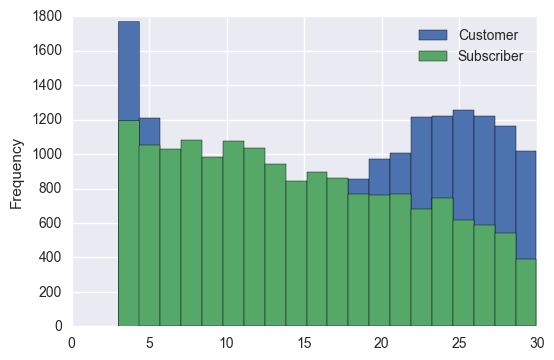

In [26]:
# examine the <30 minute ride distribution again
sameStationTrips[sameStationTrips['tripInMinutes'] < 30] \
    .groupby('usertype')['tripInMinutes'] \
    .plot(kind='hist', stacked=True, legend=True, bins=20)

In [27]:
# Acording to Folium docs, we can pass the heatmap function a (n, 3) ndarray
# with weights in the column
sameStationCountsByStationID = sameStationTrips \
                                .groupby('from_station_id')['trip_id'] \
                                .agg('count')
sameStationCountsByStationID.name = 'numTrips'

In [28]:
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByStationID.to_frame(), 
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['numTrips'].fillna(value=0)

In [29]:
sameStationCountsDF.head(2)

,id,name,latitude,longitude,dpcapacity,online_date,numTrips
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,6.0
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,137.0


# Right now it's difficult to get a map up and running easily

### Let's make a helper function

In [30]:
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix()
        curr_map.add_children(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [31]:
map_points(sameStationCountsDF, plot_points=True, draw_heatmap=True, heat_map_weights_normalize=True, 
           heat_map_weights_col='numTrips')

# See the heatmaps of different types of users (subscribers / customers)

In [32]:
sameStationCountsByUserTypeStationID = \
    sameStationTrips[['from_station_id', 'usertype', 'trip_id']] \
    .groupby(('usertype', 'from_station_id'))\
    .agg('count')

In [33]:
selected = 'Customer'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

map_points(sameStationCountsDF, plot_points=False, draw_heatmap=True, 
           heat_map_weights_normalize=False, heat_map_weights_col='numTrips', heat_map_radius=9)

In [34]:
selected = 'Subscriber'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

map_points(sameStationCountsDF, plot_points=False, draw_heatmap=True, 
           heat_map_weights_normalize=False, heat_map_weights_col='numTrips', heat_map_radius=9)